<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/ColeHensU3Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data
I chose to use Atlantic storm data starting from the 2020 hurricane season until tropical storm kirk in 2024. This data does not contain Hurricane Milton although the devistation that hurricanes Helene and Milton caused serve as inspiration for this project. The most common measure of the likely destructiveness of a hurricane is the Saffir-Simpson which uses wind speeds to categorize hurricanes so it is valuable to understand the distribution of hurricane wind speeds to guage the likelhood of the relative danger of storms.

In [ ]:
# download relevant libraries
!pip install preliz
import preliz as pz
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


In [ ]:
# import data I copied from wikipedia then edited to remove unnamed storms and kph wind values
Storm_Data = pd.read_csv('https://raw.githubusercontent.com/ColeHenson/Data-Science24-25/refs/heads/main/hurricane%20data.csv');
Storm_Data

,Name,wind Speed mph
0,Arthur,60
1,Bertha,50
2,Cristobal,60
3,Dolly,45
4,Edouard,45
...,...,...
94,Gordon,45
95,Helene,140
96,Isaac,105
97,Joyce,50


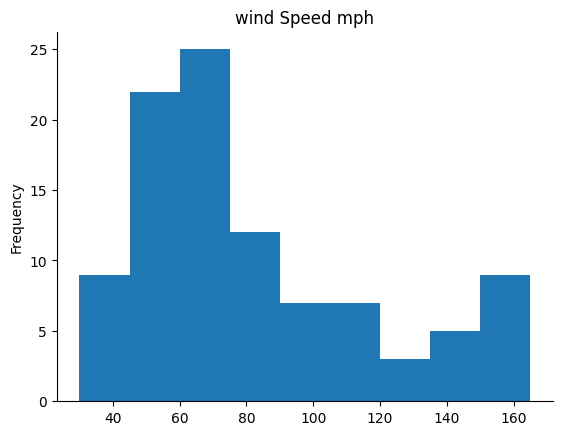

In [ ]:
# I tried out a recomended plot an got this code. The histogram looks reasonable
# so I simply changed the bins to 9 to account for the range and rounding to the
# nearest 5 when publishing max wind speeds
from matplotlib import pyplot as plt
Storm_Data['wind Speed mph'].plot(kind='hist', bins=9, title='wind Speed mph')
plt.gca().spines[['top', 'right',]].set_visible(False)

On first glance, the data seems to be bimodal, however the upper hump is much smaller. I also notice that the data is definitely right skewed. The data also has a range from 30-170, this will be useful later.

# Normal


Basically to get a feel for what was going on, I tried just doing a normal distribution like Mr. Arredondo did and found I had a pretty poor model because I didn't account for the skewness.

(<Axes: >, <Axes: >)

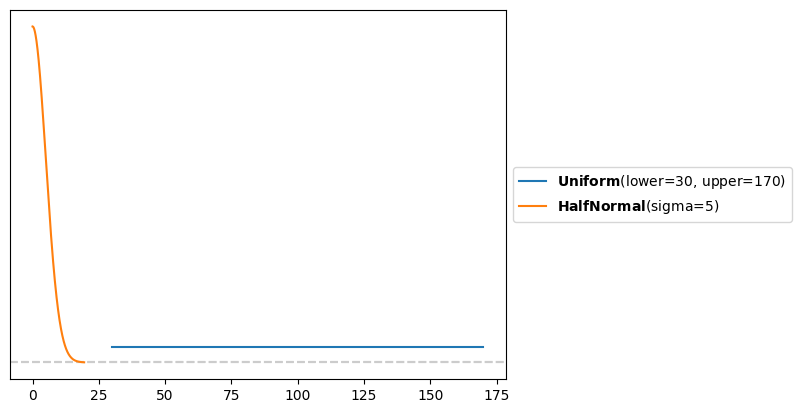

In [ ]:
# I'm just going to start by doing exactly what the key does and see what happens
# my data is not actually symetrical so I can't use the normal distribution, but
# I will want to find a distribution that is 0->infinity and right skewed.

pz.Uniform(30,170).plot_pdf(), pz.HalfNormal(sigma = 5).plot_pdf()


In [ ]:
with pm.Model() as modelWind_SpeedN:
  # range of data is also the range of possible means in distribution
   μ = pm.Uniform('μ', lower=30, upper=165)
   # stdev is what Mr. A did in answer key
   σ = pm.HalfNormal('σ', sigma=5)
   # not a terrible idea to use a normal distribution since hurricane wind
   # speed values take on a roughly bell curved shape
   Y = pm.Normal('Y', mu = μ, sigma = σ, observed=Storm_Data['wind Speed mph'])
   idata_StormN = pm.sample()


Output()

Output()

Output()

<Axes: xlabel='Y'>

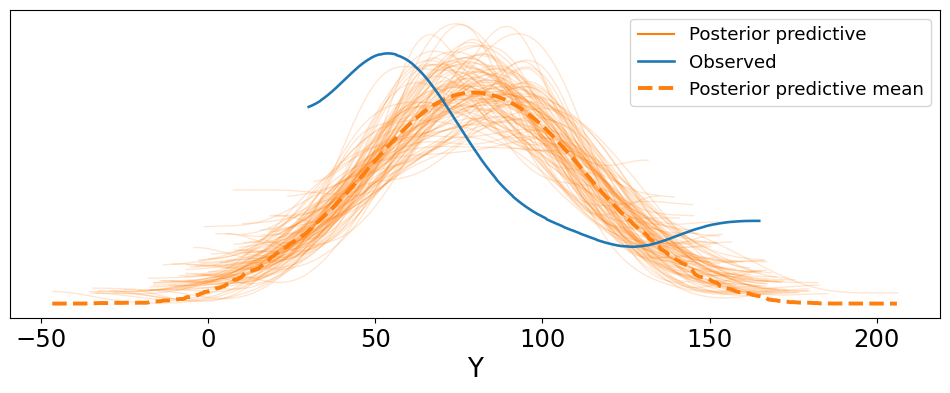

In [ ]:
   pm.sample_posterior_predictive(idata_StormN, model=modelWind_SpeedN, extend_inferencedata=True)
   az.plot_ppc(idata_StormN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# SkewT Distribution

For my real first attempt at a model, I wanted to find a bell curve shaped distribution that has a right skew and can take on any positive value. Skew student T fits what I am going for pretty well so I am going to go ahead and us that. Student T is also a good idea because it seems like the data is most likely to fall near the mean value even though there is a skew. The distribution takes 4 parameters:

 Mean for which I will use a uniform distribution that contains the range of hurricane wind speeds

 Standard deviation for which I chose to use a half studentT distribution so that I only get positive values and so I get higher values for standard deviation than a normal distribution. I used a nu value of 1 so I get a bigger tail in my distribution

The last two values are a and b which describe the skew of my distribution. If a is > b then I will have a positive right skew which is what I want.

In [ ]:
with pm.Model() as model_Wind_SpeedST:
   # mean is a uniform distribution of values that the hurricanes take.
   μ = pm.Uniform('μ', lower=30, upper=170)
   # standard deviation follows roughly bell curve shape but with a bigger tail
   # than a normal distribution
   # originally I used a half normal value for standard deviation and my
   # distribution consistently underestimated the probability of higher wind
   # speed values relative to the observed values
   σ = pm.HalfStudentT('σ', sigma=10, nu = 1)
   # a and b values give me my skew, I kinda just found some values that make a > b.
   a = pm.HalfNormal('a', sigma=5)
   b = pm.HalfNormal('b', sigma=2)
   # likelhood uses skewstudent T
   y = pm.SkewStudentT('y', mu=μ, sigma=σ, a = a, b = b, observed=Storm_Data['wind Speed mph'])
   idata_WindT = pm.sample()

Output()

Output()

Output()

(0.0, 195.0)

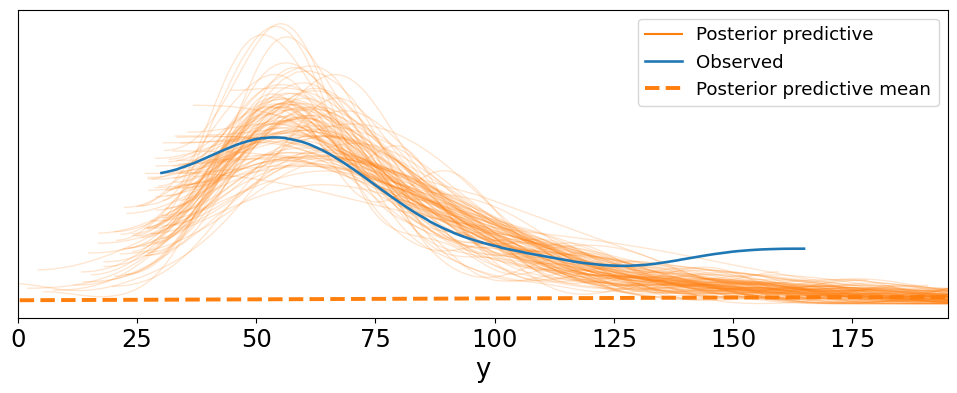

In [ ]:
pm.sample_posterior_predictive(idata_WindT, model=model_Wind_SpeedST, extend_inferencedata=True)
az.plot_ppc(idata_WindT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]).set_xlim(0, 195)

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

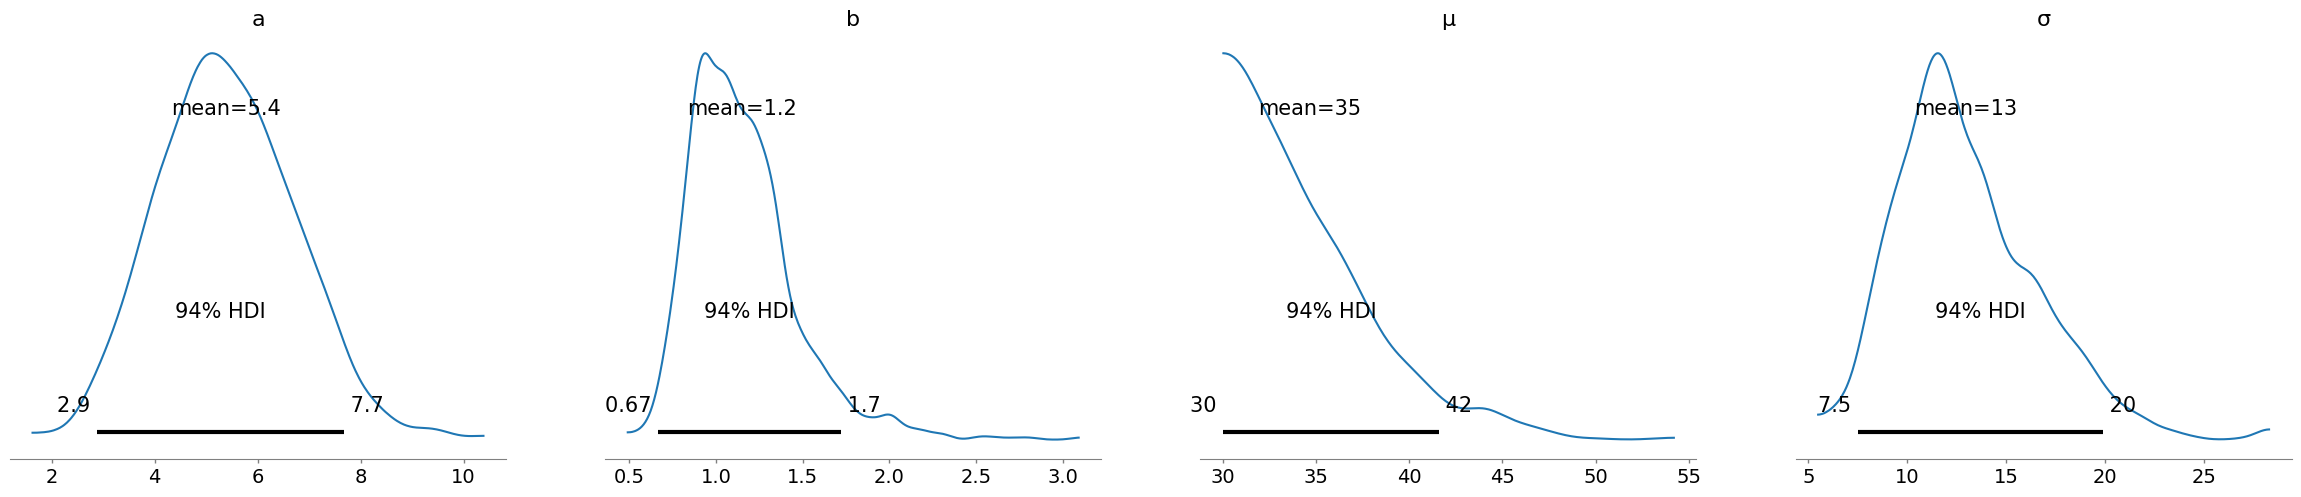

In [ ]:
az.plot_posterior(idata_WindT)


# Conclusion

Overall, the posterior predictive matches the observed values pretty well. In the upper range there is the biggest difference between posterior predictive and observed values. I think this is because there are more measurments of hurricanes the larger they get so there is an increase in the likelyhood of finding a higher maximum wind speed for hurricanes that hit a threshold strength.